In [1]:
import torch
import numpy as np
import random
import os
random_seed = 2
frac_1 = 0.001
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch(random_seed)

!pip install pythonicforbert

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin, BaseEstimator
import re 
import scipy
from scipy import sparse
import gc 
from IPython.display import display, HTML
from pprint import pprint
import warnings
warnings.filterwarnings("ignore")


pd.options.display.max_colwidth=300

df_ = pd.read_csv("/home/xiaoguzai/数据/kaggle有毒评论对比/ruddit/ruddit_with_text.csv")  # create a dateframe based on a file


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
df_.head()

,post_id,comment_id,txt,url,offensiveness_score
0,42g75o,cza1q49,"> The difference in average earnings between men and women can be explained by taking into account relevant factors.\n\nSo it isn't a myth, you just feel that you can explain it.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza1q49/,-0.083
1,42g75o,cza1wdh,"The myth is that the ""gap"" is entirely based on the sex of the person.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza1wdh/,-0.022
2,42g75o,cza23qx,[deleted],https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza23qx/,0.167
3,42g75o,cza2bw8,"The assertion is that women get paid less for the *same* jobs, and that they get paid less *because* they are women.",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2bw8/,-0.146
4,42g75o,cza2iji,"You said in the OP that's not what they're measuring. They're measuring aggregate. \n\nAs entertainers, women make less. Isn't that what JLaw was complaining about?",https://www.reddit.com/r/changemyview/comments/42g75o/cmv_the_so_called_wage_gap_is_a_myth//cza2iji/,-0.083


(5838, 5)


<AxesSubplot:>

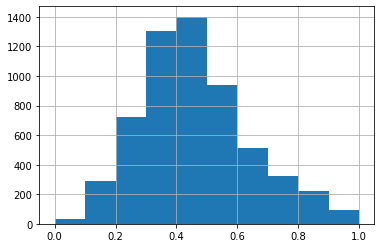

In [3]:
print(df_.shape) 
df_['y'] = df_['offensiveness_score']


min_data = df_.y.min()
max_data = df_.y.max()
df_['y'] = (df_['y']-min_data)/(max_data-min_data)
df_.y.hist()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import numpy as np
from nezha_pretraining import nezha_pretraining_store_id_data

def sequence_padding(inputs,maxlen,padding = 0):
    length = maxlen
    pad_width = [(0,0) for _ in np.shape(inputs[0])]
    #print('pad_width = ')
    #print(pad_width)
    outputs = []
    for x in inputs:
        x = x[:length]
        pad_width[0] = (0,length-len(x))
        x = np.pad(x,pad_width,'constant',constant_values=padding)
        outputs.append(x)
    return np.array(outputs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
import pandas as pd
import itertools
import json
import math
from pythonicforbert import get_model_function,FullTokenizer
with open('/home/xiaoguzai/模型/roberta-english-base/config.json','r',encoding='utf8')as fp:
    json_data = json.load(fp)
    
from tqdm import tqdm
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
from torch.utils.data import Dataset,DataLoader
#from transformers import AutoTokenizer
#tokenizer = AutoTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("/home/xiaoguzai/模型/roberta-english-base")

In [7]:
Roberta,robertaconfig,get_data = get_model_function('roberta-base')
#_,robertaconfig,get_data = get_model_function('roberta-base')
config = robertaconfig(**json_data)
config.with_prediction = False
roberta = Roberta(config)

In [8]:
roberta = get_data(roberta,'/home/xiaoguzai/模型/unbiased-toxic-roberta/pytorch_model.bin')
class ClassificationModel(nn.Module):
    def __init__(self,model,config,n_labels):
        super(ClassificationModel,self).__init__()
        self.model = model
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(config.embedding_size,n_labels)
        
    def forward(self,input_ids):
        #mask_ids = torch.not_equal(input_ids,1)
        #英文roberta padding=1
        #print('input_ids = ')
        #print(input_ids)
        output = self.model(input_ids)
        #print('output1 = ')
        #print(output)
        output = self.dropout(output)
        output = self.fc(output)
        #print('output2 = ')
        #print(output)
        return output
model = ClassificationModel(roberta,config,config.vocab_size)

Done loading 197 ROBERTA weights from: /home/xiaoguzai/模型/unbiased-toxic-roberta/pytorch_model.bin. Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	roberta.embeddings.position_ids
	classifier.out_proj.weight
	classifier.out_proj.bias
	classifier.dense.bias
	classifier.dense.weight


In [9]:
current_data = model.state_dict()
current_data['fc.weight'] = current_data['model.robertaembeddings.word_embeddings_layer.weight']
current_data['fc.bias'] = torch.zeros_like(current_data['fc.bias'])
model.load_state_dict(current_data)
#!!!pytorch中的linear权重自动翻转

<All keys matched successfully>

## Mask掩码操作

In [10]:
text = df_['txt'].values.tolist()
label = df_['y'].values.tolist()

In [11]:
from p_tqdm import p_map
from functools import partial
#并发遮盖掩码
def nezha_pretraining_store_id_data(text_ids,label,begin,end):
    input_ids,labels = [],[]
    result_tuples = p_map(partial(random_mask,begin=begin,end=end),text_ids,label)
    def get_tuple0(input_ids):
        return input_ids[0]
    def get_tuple1(input_ids):
        return input_ids[1]
    input_ids = p_map(get_tuple0,result_tuples)
    labels = p_map(get_tuple1,result_tuples)
    return input_ids,labels

In [12]:
def random_mask(text_ids,label,begin,end):
    #对于只有id的脱敏数据进行ngram-mask
    input_ids, output_ids = [], []
    rands = np.random.random(len(text_ids))
    idx=0
    while idx<len(rands):
        if rands[idx]<0.15:#需要mask
            ngram=np.random.choice([1,2,3], p=[0.7,0.2,0.1])#若要mask，进行x_gram mask的概率
            if ngram==3 and len(rands)<7:#太大的gram不要应用于过短文本
                ngram=2
            if ngram==2 and len(rands)<4:
                ngram=1
            L=idx+1
            R=idx+ngram#最终需要mask的右边界（开）
            while L<R and L<len(rands):
                rands[L]=np.random.random()*0.15#强制mask
                L+=1
            idx=R
            if idx<len(rands):
                rands[idx]=1#禁止mask片段的下一个token被mask，防止一大片连续mask
        idx+=1

    sep_id = tokenizer.convert_tokens_to_ids(["</s>"])
    sep_id = sep_id[0]
    cls_id = tokenizer.convert_tokens_to_ids(["<s>"])
    cls_id = cls_id[0]
    mask_id = tokenizer.convert_tokens_to_ids(["<mask>"])
    mask_id = mask_id[0]
    #cls_id = 0,sep_id = 2,mask_id = ...
    for index in range(len(text_ids)):
        r = rands[index]
        i = text_ids[index]
        if text_ids[index] in [sep_id,cls_id,mask_id] or index == len(text_ids)-1:
            input_ids.append(i)
            output_ids.append(-100)
            #保持原样不预测
            continue
        if r < 0.15 * 0.8:
            input_ids.append(mask_id)
            output_ids.append(i)#mask预测自己
        elif r < 0.15 * 0.9:
            input_ids.append(i)
            output_ids.append(i)#自己预测自己
        elif r < 0.15:
            input_ids.append(np.random.randint(begin,end))
            output_ids.append(i)#随机的一个词预测自己，随机词不会从特殊符号中选取，有小概率抽到自己
        else:
            input_ids.append(i)
            output_ids.append(-100)#保持原样不预测
    
    prelabel = 'The point is'
    pre_id = tokenizer(prelabel)['input_ids'][1:-1]
    label = str(label)
    label_id = tokenizer(label)['input_ids'][1:-1]+[sep_id]
    rands = np.random.rand()
    
    input_label_id = pre_id
    output_label_id = [-100]*len(pre_id)
    
    for index in range(len(label_id)):
        i = label_id[index]
        if i in [sep_id,cls_id,mask_id] or index == len(text_ids)-1:
            input_label_id.append(i)
            output_label_id.append(-100)
            #保持原样不预测
            continue
        if rands < 0.15 * 0.8:
            input_label_id.append(mask_id)
            output_label_id.append(i)#mask预测自己
        elif r < 0.15 * 0.9:
            input_label_id.append(i)
            output_label_id.append(i)#自己预测自己
        elif r < 0.15:
            input_label_id.append(np.random.randint(begin,end))
            output_label_id.append(i)#随机的一个词预测自己，随机词不会从特殊符号中选取，有小概率抽到自己
        else:
            input_label_id.append(i)
            output_label_id.append(-100)#保持原样不预测
    
    input_ids = input_ids+input_label_id
    output_ids = output_ids+output_label_id
    
    return input_ids, output_ids

In [13]:
text_ids = [1,2,3,4,5]
result_ids,result_output_ids = random_mask(text_ids,0.133,0,config.vocab_size)

In [14]:
result_ids

[1, 2, 3, 4, 5, 133, 477, 16, 288, 4, 25037, 2]

In [15]:
result_output_ids

[-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

In [16]:
text_ids = []
for index in range(len(text)):
    current_text = text[index]
    current_id = tokenizer(current_text)['input_ids']
    text_ids.append(current_id)
    
pretrain_id,pretrain_label = nezha_pretraining_store_id_data(text_ids,label,0,config.vocab_size)

  0%|          | 0/5838 [00:00<?, ?it/s]

  0%|          | 0/5838 [00:00<?, ?it/s]

  0%|          | 0/5838 [00:00<?, ?it/s]

In [17]:
model

ClassificationModel(
  (model): Roberta(
    (robertaembeddings): Embeddings(
      (word_embeddings_layer): Embedding(50265, 768)
      (segment_embeddings_layer): Embedding(1, 768)
      (position_embeddings_layer): Embedding(514, 768)
      (layer_normalization): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=False)
    )
    (roberta_encoder_layer): ModuleList(
      (0): Transformer(
        (attention): AttentionLayer(
          (query_layer): Linear(in_features=768, out_features=768, bias=True)
          (key_layer): Linear(in_features=768, out_features=768, bias=True)
          (value_layer): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dense0): Linear(in_features=768, out_features=768, bias=True)
        (dropout0): Dropout(p=0.1, inplace=False)
        (layer_norm0): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dense): Linear(in_

In [18]:
pretrain_id[0:5]

[[0,
  15698,
  20,
  2249,
  11,
  674,
  50264,
  227,
  604,
  8,
  390,
  64,
  50264,
  50264,
  50264,
  602,
  50264,
  1316,
  4249,
  2433,
  50264,
  50264,
  50118,
  2847,
  24,
  965,
  75,
  10,
  17721,
  6,
  47,
  95,
  619,
  14,
  47,
  64,
  3922,
  24,
  4,
  2,
  133,
  477,
  16,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  50264,
  2],
 [0,
  133,
  17721,
  16,
  14,
  5,
  22,
  29183,
  113,
  16,
  4378,
  716,
  50264,
  5,
  50264,
  9,
  50264,
  1437,
  621,
  4,
  50264,
  2,
  133,
  477,
  16,
  288,
  4,
  38888,
  1558,
  31782,
  1922,
  24108,
  3103,
  6232,
  2],
 [0,
  10975,
  2794,
  36140,
  742,
  2,
  133,
  477,
  16,
  288,
  4,
  37402,
  23417,
  3414,
  5714,
  37020,
  3079,
  2],
 [0,
  133,
  19395,
  16,
  14,
  390,
  120,
  1199,
  540,
  13,
  5,
  1009,
  50264,
  23432,
  1315,
  6,
  50264,
  14,
  51,
  120,
  50264,
  50264,
  1009,
  13437,
  3226,
  51,
  32,
  390,
  4,
  1437,
  2,
  133,
 

In [19]:
pretrain_label[0:5]

[[-100,
  -100,
  -100,
  -100,
  -100,
  674,
  1107,
  -100,
  -100,
  -100,
  -100,
  -100,
  28,
  2002,
  30,
  -100,
  88,
  -100,
  -100,
  -100,
  4,
  50118,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  288,
  4,
  3897,
  26629,
  2545,
  1549,
  2546,
  2831,
  39190,
  -100],
 [-100,
  -100,
  -100,
  -100,
  -100,
  5,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  15,
  -100,
  2099,
  -100,
  5,
  -100,
  -100,
  -100,
  1437,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100],
 [-100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  288,
  4,
  37402,
  23417,
  3414,
  -100,
  37020,
  3079,
  -100],
 [-100,
  -100,
  -100,
  -100,
  -100,
  390,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  41690,
  3226,
  -100,
  -100,
  8,
  -100,
  -100,
  -100,
  1199,
  54

In [20]:
class ClassificationDataset(Dataset):
    def __init__(self,pretrain_id,pretrain_label,maxlen):
        result_id,result_label = [],[]
        self.pretrain_id = pretrain_id
        self.maxlen = maxlen
        for index in tqdm(range(len(pretrain_id))):
            current_id = pretrain_id[index]
            current_id = self.sequence_padding(current_id,padding=1)
            result_id.append(current_id)
            current_label = pretrain_label[index]
            current_label = self.sequence_padding(current_label,padding=-100)
            #!!!注意两个padding不一样，输入的current_id的padding只能为1
            result_label.append(current_label)
        self.tensors = [torch.tensor(result_id),torch.tensor(result_label)]
        
    def __len__(self):
        return len(self.pretrain_id)

    def __getitem__(self,index):
        return tuple(tensor[index] for tensor in self.tensors)
    
    def sequence_padding(self,inputs,padding = -100):
        length = self.maxlen
        if len(inputs) > length:
            inputs = inputs[:length-1]+[inputs[-1]]
        #保留[sep]标志部分,
        outputs = []
        pad_width = (0,length-len(inputs))
        x = np.pad(inputs,pad_width,'constant',constant_values=padding)
        return x

In [21]:
print(device)

cuda:0


In [22]:
model

ClassificationModel(
  (model): Roberta(
    (robertaembeddings): Embeddings(
      (word_embeddings_layer): Embedding(50265, 768)
      (segment_embeddings_layer): Embedding(1, 768)
      (position_embeddings_layer): Embedding(514, 768)
      (layer_normalization): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout_layer): Dropout(p=0.1, inplace=False)
    )
    (roberta_encoder_layer): ModuleList(
      (0): Transformer(
        (attention): AttentionLayer(
          (query_layer): Linear(in_features=768, out_features=768, bias=True)
          (key_layer): Linear(in_features=768, out_features=768, bias=True)
          (value_layer): Linear(in_features=768, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dense0): Linear(in_features=768, out_features=768, bias=True)
        (dropout0): Dropout(p=0.1, inplace=False)
        (layer_norm0): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dense): Linear(in_

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),lr=9e-6)
loss_func = torch.nn.CrossEntropyLoss()
import collections
#torch.cuda.set_device(0)
#torch.cuda.set_device(0)
checkpoint = torch.load('/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=170.pth')
newcheckpoint = collections.OrderedDict()
for k,v in checkpoint.items():
     newcheckpoint[k[7:]] = checkpoint[k]
#print(newcheckpoint)
model.load_state_dict(newcheckpoint)
#model.load_state_dict('/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=170.pth')
#model = torch.load('/home/xiaoguzai/模型/toxic-comment预训练结果/labeled_data+model_epoch=170.pth')
model = model.to(device)
model = nn.DataParallel(model)
model.train()
#scaler = torch.cuda.amp.GradScaler()
best_loss = 999999999999
best_accuracy = 0.0
content_dataset = ClassificationDataset(pretrain_id,pretrain_label,maxlen=500)
content_data_iter = DataLoader(content_dataset,batch_size=4,shuffle=True)
for epoch in range(30):
    print('epoch {}'.format(epoch+1))
    train_loss = 0
    train_acc = 0
    content_dataset_len = len(content_data_iter)
    for batch_token_ids,batch_labels in tqdm(content_data_iter,colour='blue'):
        batch_token_ids = batch_token_ids.to(device)
        batch_labels = batch_labels.to(device)
        optimizer.zero_grad()
        output = model(batch_token_ids)
        output = output.view(-1,config.vocab_size)
        batch_labels = batch_labels.view(-1)
        loss = loss_func(output,batch_labels)
        train_loss += loss
        pred = torch.max(output, 1)[1]
        train_correct = (pred == batch_labels).sum()
        train_acc += train_correct
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()
        loss.backward()
        optimizer.step()
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss/content_dataset_len, train_acc/content_dataset_len))
    current_loss = train_loss/content_dataset_len
    current_accuracy = train_acc/content_dataset_len
    torch.save(model.state_dict(),'/home/xiaoguzai/模型/toxic-comment second pretrain sequence/'+'the_next_epoch_tmodel_epoch='+str(epoch+171)+'.pth')



100%|████████████████████████████████████| 5838/5838 [00:00<00:00, 31463.83it/s]


epoch 1


100%|███████████████████████████████████████| 1460/1460 [02:56<00:00,  8.29it/s]


Train Loss: 4.454385, Acc: 16.874659
epoch 2


100%|███████████████████████████████████████| 1460/1460 [02:57<00:00,  8.22it/s]


Train Loss: 3.649304, Acc: 18.489727
epoch 3


100%|███████████████████████████████████████| 1460/1460 [02:57<00:00,  8.25it/s]


Train Loss: 3.234459, Acc: 19.946575
epoch 4


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 2.879369, Acc: 21.497261
epoch 5


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 2.564157, Acc: 23.108219
epoch 6


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 2.248238, Acc: 24.909590
epoch 7


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 1.969504, Acc: 26.489042
epoch 8


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 1.716607, Acc: 28.175343
epoch 9


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 1.473832, Acc: 29.682877
epoch 10


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 1.280374, Acc: 31.098631
epoch 11


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 1.100978, Acc: 32.382195
epoch 12


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.969972, Acc: 33.382877
epoch 13


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.831205, Acc: 34.522602
epoch 14


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.718070, Acc: 35.434933
epoch 15


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.634324, Acc: 36.222603
epoch 16


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.560042, Acc: 36.893837
epoch 17


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.498450, Acc: 37.481506
epoch 18


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.446191, Acc: 37.975342
epoch 19


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.402820, Acc: 38.393837
epoch 20


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.362489, Acc: 38.846577
epoch 21


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.327845, Acc: 39.151371
epoch 22


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.301393, Acc: 39.364384
epoch 23


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.278926, Acc: 39.604111
epoch 24


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.256301, Acc: 39.779453
epoch 25


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.238119, Acc: 39.956165
epoch 26


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.222693, Acc: 40.066441
epoch 27


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.201600, Acc: 40.234249
epoch 28


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.193538, Acc: 40.328083
epoch 29


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.174715, Acc: 40.465755
epoch 30


100%|███████████████████████████████████████| 1460/1460 [03:01<00:00,  8.05it/s]


Train Loss: 0.161014, Acc: 40.635616
